In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
import warnings
warnings.filterwarnings(action = 'ignore')

## Loading data

In [2]:
df = pd.read_csv("../input/rainfall-timeseries-data/Rainfall_data.csv")

In [3]:
df.head()

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
0,2000,1,1,8.06,48.25,23.93,0.00
1,2000,2,1,8.73,50.81,25.83,0.11
2,2000,3,1,8.48,42.88,26.68,0.01
3,2000,4,1,13.79,55.69,22.49,0.02
4,2000,5,1,17.40,70.88,19.07,271.14


In [4]:
df.describe()

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
count,252.000000,252.000000,252.0,252.000000,252.000000,252.000000,252.000000
mean,2010.000000,6.500000,1.0,14.416746,67.259524,16.317262,206.798929
std,6.067351,3.458922,0.0,4.382599,17.307101,6.584842,318.093091
min,2000.000000,1.000000,1.0,5.740000,34.690000,4.730000,0.000000
25%,2005.000000,3.750000,1.0,10.010000,51.845000,10.865000,0.402500
50%,2010.000000,6.500000,1.0,15.200000,66.655000,16.915000,11.495000
75%,2015.000000,9.250000,1.0,18.875000,84.610000,22.115000,353.200000
max,2020.000000,12.000000,1.0,20.570000,92.310000,29.340000,1307.430000


#### setting date as index


In [5]:
df['DATE'] = pd.to_datetime(df[['Year', 'Month','Day']])
df = df.drop(columns=['Year', 'Month','Day'])
df.index = df["DATE"]
df.drop(columns=["DATE"],inplace = True)
df

,Specific Humidity,Relative Humidity,Temperature,Precipitation
DATE,,,,
2000-01-01,8.06,48.25,23.93,0.00
2000-02-01,8.73,50.81,25.83,0.11
2000-03-01,8.48,42.88,26.68,0.01
2000-04-01,13.79,55.69,22.49,0.02
2000-05-01,17.40,70.88,19.07,271.14
...,...,...,...,...
2020-08-01,20.08,92.31,5.34,1203.09
2020-09-01,19.71,90.12,9.22,361.30
2020-10-01,18.43,82.69,12.62,180.18


<AxesSubplot:xlabel='DATE'>

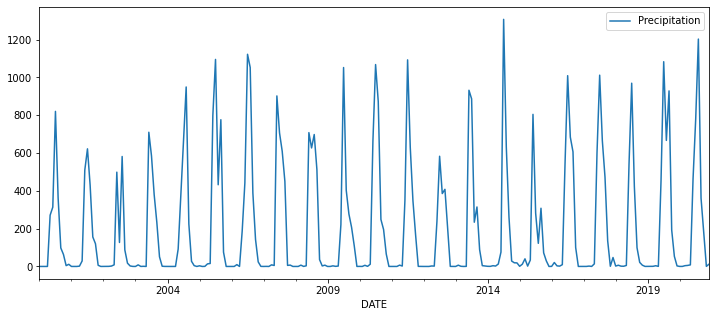

In [6]:
rain = pd.DataFrame(df["Precipitation"])
rain.index.freq = 'MS'
rain.plot()

## Seasonal Decomposition

* A time series data is composed of 
    * Trend: Trend is the overall direction of the data.
    * Seasonlity: Seasonality is a periodic component which repeats itself within a particulat time period.
    * Residuals: the residual is what’s left over when the trend and seasonality have been removed. Residuals are random fluctuations.
 

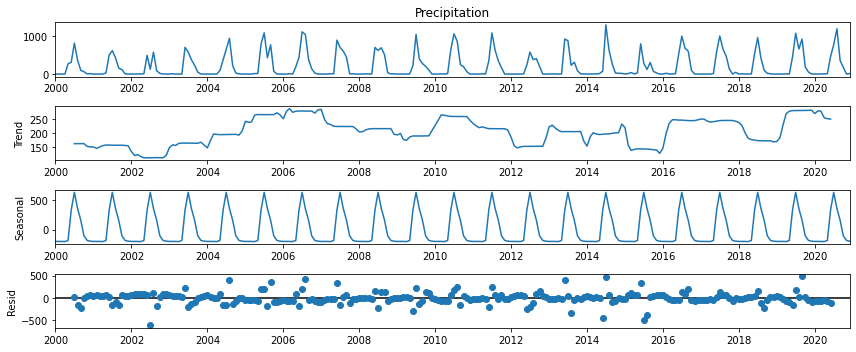

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
add = seasonal_decompose(rain["Precipitation"],model='add',period = 12)
add.plot();

**Looking at the plot it clearly visible that there is seasonality in the data and some trend**

## Train and Test Split
Train test split in timeseries is different as copared to Machine learning Algforithms. We do random split there where the time component does'nt matters.
But in time series we have information dependent on time therefore the spliting is continous without any shuffling of data.
* Using 20 years data for training (2000-01-01 to 2019-12-01)
* Using 1 year data for Testing (2020-01-01 to 2020-12-01)

In [8]:
df.shape

(252, 4)

In [9]:
test_period = 12
len(df)-12 ## 12 is our testing period

240

In [10]:
# training
train_data = df.iloc[:len(df)-test_period,:]
# testing
test_data = df.iloc[len(df)-test_period:,:]

In [11]:
test_data.shape

(12, 4)

## Usefull Fonctions

In [12]:
def plotting(test_predictions):
    train_data['Precipitation'].plot(legend=True,label='TRAIN')
    test_data['Precipitation'].plot(legend=True,label='TEST',figsize=(13,7));
    test_predictions.plot(legend=True,label='PREDICTION');

In [13]:
def zoom_plotting(test_predictions):
    train_data['Precipitation'].plot(legend=True,label='TRAIN')
    test_data['Precipitation'].plot(legend=True,label='TEST',figsize=(13,7))
    test_predictions.plot(legend=True,label='PREDICTION',xlim=['2020-01-01','2020-12-01']);


In [14]:
def metrics(test_data,test_predictions):
    print("MAE: ",mean_absolute_error(test_data,test_predictions))
    print("MSE: ",mean_squared_error(test_data,test_predictions))
    print("RMSE: ",np.sqrt(mean_squared_error(test_data,test_predictions)))

## NOTE: Exponential Smoothing

* Exponential smoothing is generally used to make short-term forecasts
* More recent observations are given larger weights by exponential smoothing
* Exponential Smoothing Methods
    * Simple or Single Exponential Smoothing
    * Double Exponential Smoothing
    * Triple Exponential Smoothing


**Single Exponential Smoothing**
* If the data has no trend and no seasonal pattern, then this method of forecasting the time series is essentially used.
* This method uses weighted moving averages with exponentially decreasing weights.

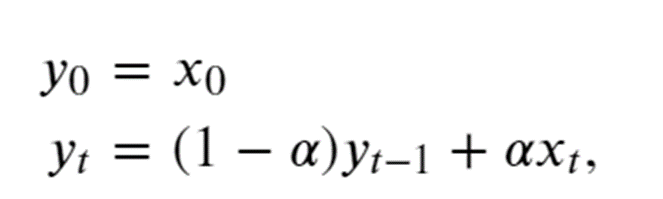

**Double Exponential Smoothing**
* This method is also called as Holt’s trend corrected or second-order exponential smoothing. 
* This method is used for forecasting the time series when the data has a linear trend and no seasonal pattern.
* It introduces a new smoothing factor beta that addresses trend in data
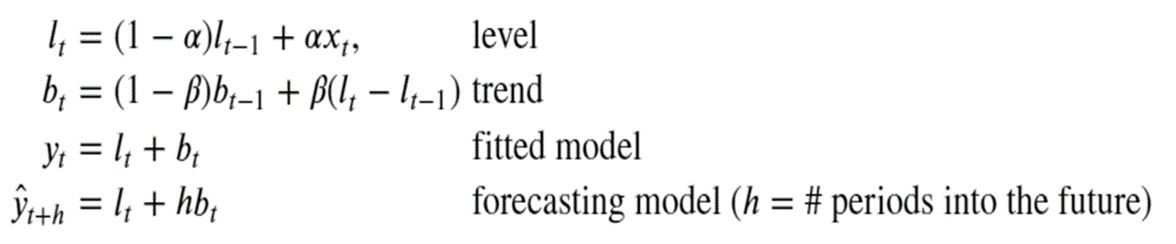

**Triple Exponential Smoothing**
* In this method, exponential smoothing applied three times.
* This method is used for forecasting the time series when the data has both linear trend and seasonal pattern. 
* This method is also called **Holt-Winters exponential smoothing.**
* It introduces a new smoothing factor  γ that addresses seasonality in data

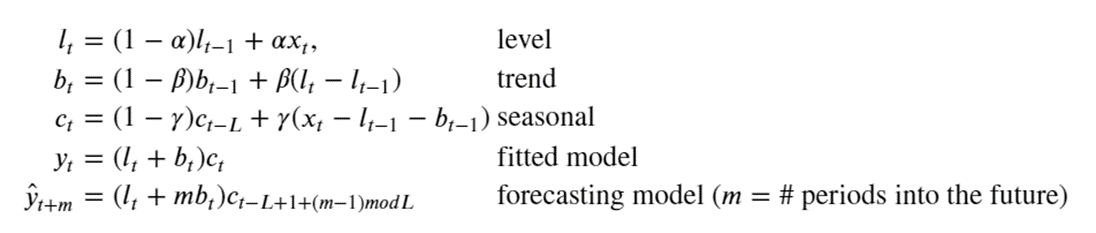

# 1. Simple Seasonal Exponential Smoothing 

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For single exponential smoothing, no need to specify trend or seasonality
single_fitted_model = ExponentialSmoothing(train_data['Precipitation']).fit()


#### Making predictions


In [16]:
test_predictions = single_fitted_model.forecast(test_period).rename('HW Forecast')
test_predictions

2020-01-01    4.257825
2020-02-01    4.257825
2020-03-01    4.257825
2020-04-01    4.257825
2020-05-01    4.257825
2020-06-01    4.257825
2020-07-01    4.257825
2020-08-01    4.257825
2020-09-01    4.257825
2020-10-01    4.257825
2020-11-01    4.257825
2020-12-01    4.257825
Freq: MS, Name: HW Forecast, dtype: float64

#### plotting


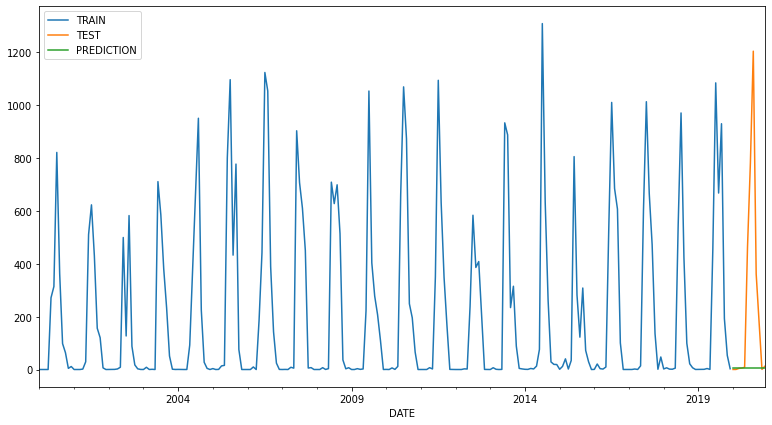

In [17]:
plotting(test_predictions)

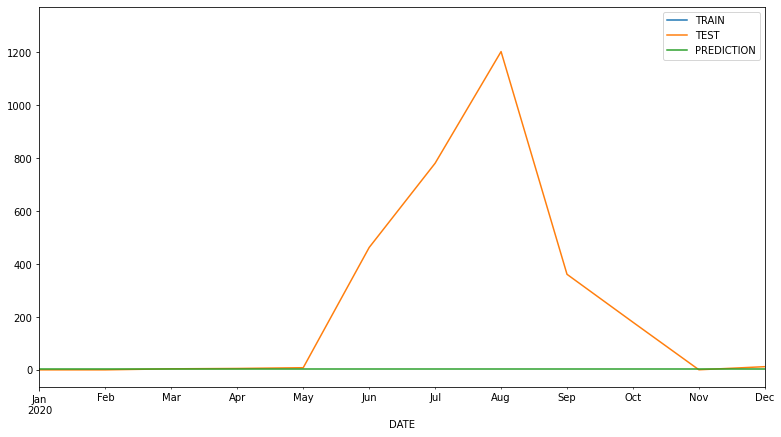

In [18]:
zoom_plotting(test_predictions)

In [19]:
print("Simple Seasonal Exponential Smoothing model: ")
metrics(test_data["Precipitation"],test_predictions)

Simple Seasonal Exponential Smoothing model: 
MAE:  249.36822499191769
MSE:  200788.65204386055
RMSE:  448.09446776752395


# 1'. Triple Seasonal Exponential Smoothing 
As we have seen in sesonal decompose the data has trend as well as seasonality we are going to use Triple exponential smoothing for making prediction

In [20]:
## For triple exponential smoothing we pass the trend,seasonality and seasonal period parameter 
triple_fitted_model = ExponentialSmoothing(train_data['Precipitation'],trend='add',seasonal = "add",seasonal_periods=test_period).fit()

#### Making predictions


In [21]:
test_predictions = triple_fitted_model.forecast(test_period).rename('HW Forecast')
test_predictions

2020-01-01     36.180860
2020-02-01     40.544612
2020-03-01     41.792990
2020-04-01     39.602761
2020-05-01     55.402008
2020-06-01    569.021000
2020-07-01    948.461690
2020-08-01    582.648214
2020-09-01    463.819483
2020-10-01    142.557653
2020-11-01     54.666720
2020-12-01     49.130298
Freq: MS, Name: HW Forecast, dtype: float64

#### plotting

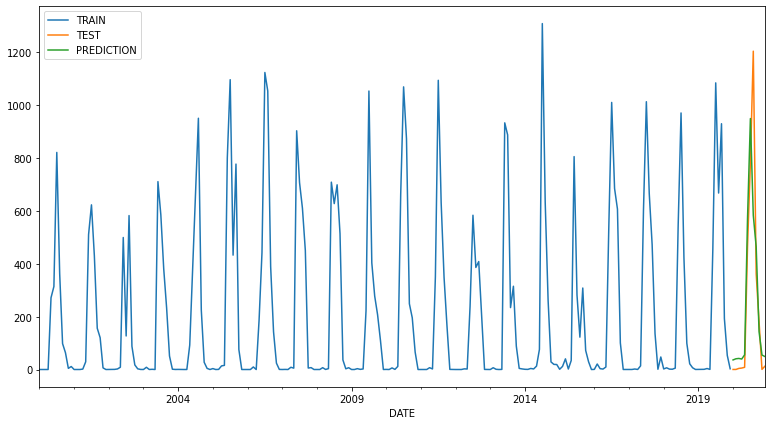

In [22]:
plotting(test_predictions)

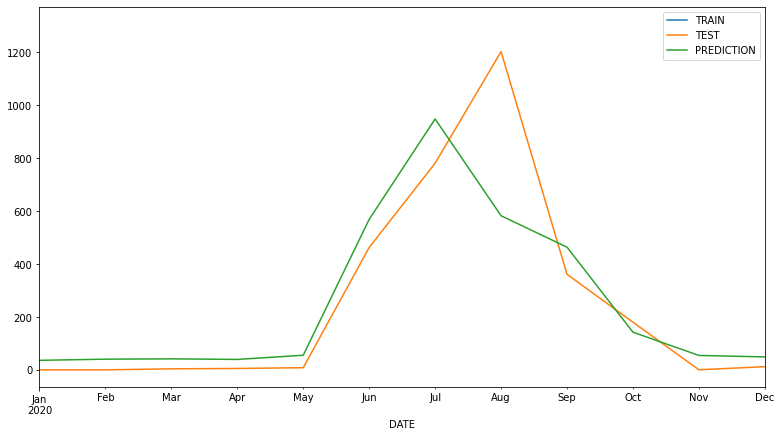

In [23]:
zoom_plotting(test_predictions)

In [24]:
print("Triple Seasonal Exponential Smoothing model: ")
metrics(test_data["Precipitation"],test_predictions)

Triple Seasonal Exponential Smoothing model: 
MAE:  110.05221286730534
MSE:  37350.36905975688
RMSE:  193.26243571826595


* Exponential Smoothing smooths the data and is simple for short-term forecasting without explaining the relationships between time points.
* ARIMA/SARIMA explicitly models the relationships between past and present values, offering deeper insights into temporal structures and more control over trend and seasonality components.

## NOTE: Auto-Regressive Integrated Moving Average (ARIMA)

* **AR (AutoRegressive)**: A model where the current value of a series depends linearly on its past values; it's applied when there is a **strong autocorrelation** in the data, meaning past values significantly influence future values.

* **MA (Moving Average)**: A model where the current value depends on past errors (residuals) over a certain period; it's applied when the data has **short-term noise** or random fluctuations that can be captured by recent forecast errors.

* **ARMA (AutoRegressive Moving Average)**: A combination of AR and MA, where the series depends on both its past values and past errors; it's applied when the data shows both temporal dependencies (AR) and random shocks or noise (MA), when **data is stationary**.

* **ARIMA (AutoRegressive Integrated Moving Average)**: An extension of the ARMA model that includes differencing to make the series stationary; it's applied when **the data has trends**, making it non-stationary, and needs to be transformed to remove long-term trends.

* **SARIMA (Seasonal ARIMA)**: An ARIMA model that includes seasonal terms to capture recurring behaviors at regular intervals; it's applied when the data shows clear **seasonal patterns**, such as yearly, monthly, or weekly cycles.


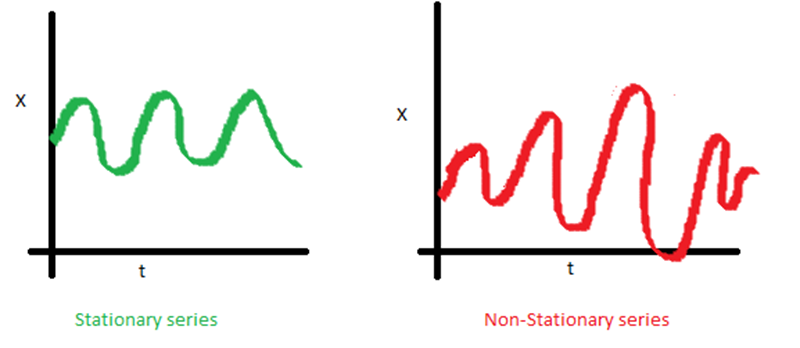



## Checking for stationarity in data

### Augemented Dickey Fullers test
Stationarity testing hypothesis: 
* Null Hypothesis: Data has unit roots which means data is **non stationary**
* Alternate hypothesis: Data does not has unit roots means data is **stationary**


In [25]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:           # using p-value
        print("-> Strong evidence against the null hypothesis")
        print("-> Reject the null hypothesis")
        print("-> Data has no unit root and is stationary")
    else:
        print("-> Weak evidence against the null hypothesis")
        print("-> Fail to reject the null hypothesis")
        print("-> Data has a unit root and is non-stationary")

In [26]:
adf_test(rain,title='rainfall')

Augmented Dickey-Fuller Test: rainfall
ADF test statistic       -2.466325
p-value                   0.123884
# lags used              12.000000
# observations          239.000000
critical value (1%)      -3.458011
critical value (5%)      -2.873710
critical value (10%)     -2.573256
-> Weak evidence against the null hypothesis
-> Fail to reject the null hypothesis
-> Data has a unit root and is non-stationary


### ACF(Auto correlation Function) and PACF(Partial auto correlation Function) plot

* **ACF:** ACF summarizes the correlation of an observation with lag values (past value)
* **PACF:** PACF summarizes the correlation of an observation with lag values that are not accounted in prior lagged observations (without considering indirect correlation)

Both Plots are drawn as barcharts showing 95% confidence interval with. Bars that cross confidence interval are more significant

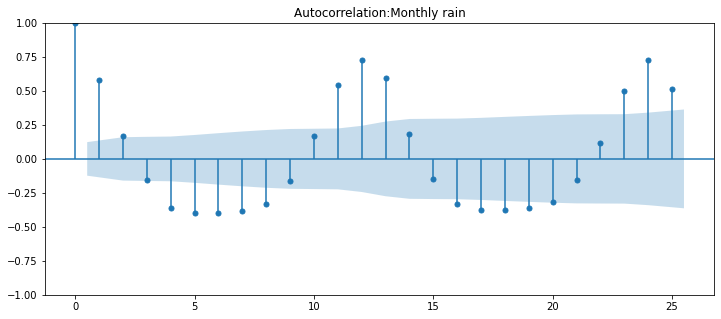

In [27]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation:Monthly rain'
plot_acf(rain,title=title);

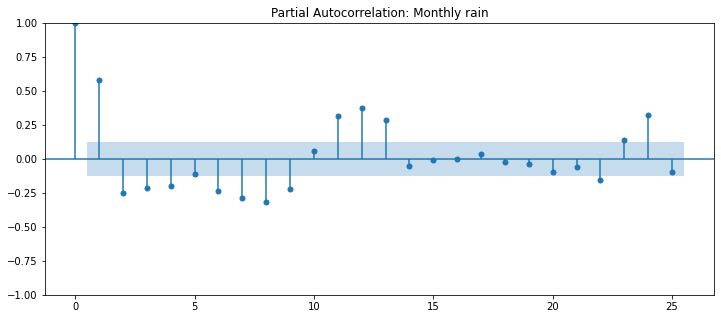

In [28]:
title='Partial Autocorrelation: Monthly rain'
plot_pacf(rain,title=title);

Both the ACF and PACF did not drop quickly, indicating that the data is not stationary.

# 2. Seasonal Autoregressive Integrated Moving Average (SARIMA) 

Using seasonal ARIMA as we know data has seasonality and trend and data is non stationary

* Train and Test Split

In [29]:
#### training
train_data = df.iloc[:len(df)-12,:]
#### testing
test_data = df.iloc[len(df)-12:,:]

## Try the selected SARIMA model in the paper which is SARIMA(0, 0, 0) (5, 1, 0)12

In [30]:
!pip install statsmodels

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

paper_model = SARIMAX(train_data['Precipitation'],order=(0,0,0),seasonal_order=(5,1,[0],12))
paper_results = paper_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16392D+00    |proj g|=  7.93594D-02


 This problem is unconstrained.



At iterate    5    f=  6.15810D+00    |proj g|=  4.35235D-04

At iterate   10    f=  6.15804D+00    |proj g|=  6.87785D-03

At iterate   15    f=  6.15711D+00    |proj g|=  7.89291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     21      1     0     0   1.291D-05   6.157D+00
  F =   6.1570320679027040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Obtain predicted values

In [32]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
paper_predictions = paper_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,0,0)(0,1,[0],12) Predictions')

Compare predictions to expected values


In [33]:
for i in range(len(paper_predictions)):
    print(f"predicted={paper_predictions[i]:<11.10}, expected={test_data['Precipitation'][i]}")

predicted=0.940206642, expected=0.17
predicted=6.212609542, expected=0.19
predicted=9.127873981, expected=4.09
predicted=1.288857636, expected=5.46
predicted=13.56646487, expected=8.29
predicted=548.85591  , expected=462.71
predicted=899.1010083, expected=781.13
predicted=486.8353838, expected=1203.09
predicted=339.0648243, expected=361.3
predicted=76.26877559, expected=180.18
predicted=12.78226171, expected=0.49
predicted=13.83057677, expected=12.23


Plot predictions against known values


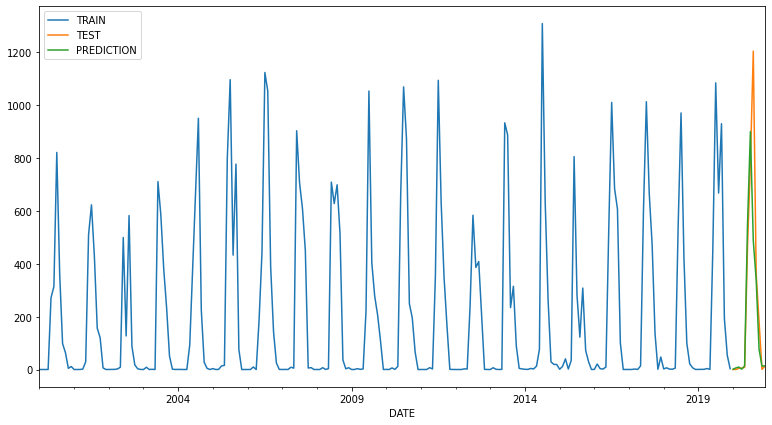

In [34]:
plotting(paper_predictions)

Plot predictions against known values


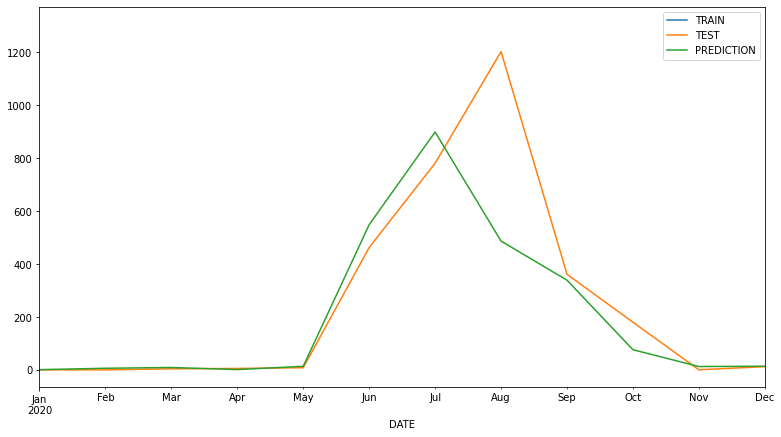

In [35]:
zoom_plotting(paper_predictions)

evaluation


In [36]:
print("Simple Seasonal Exponential Smoothing model: ")
metrics(test_data["Precipitation"],test_predictions)
print('\n')
print("Triple Seasonal Exponential Smoothing model: ")
metrics(test_data["Precipitation"],test_predictions)
print('\n')
print("Sarima paper model: ")
metrics(test_data["Precipitation"],paper_predictions)

Simple Seasonal Exponential Smoothing model: 
MAE:  110.05221286730534
MSE:  37350.36905975688
RMSE:  193.26243571826595


Triple Seasonal Exponential Smoothing model: 
MAE:  110.05221286730534
MSE:  37350.36905975688
RMSE:  193.26243571826595


Sarima paper model: 
MAE:  90.14075588291047
MSE:  45492.670315214775
RMSE:  213.29010833888844


## Use Autoarima to decide the parameters p,q,d and seasonal order

using different data means the need for different parameters for a better forcast

In [37]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.4 MB/s eta 0:00:00


In [38]:
from pmdarima import auto_arima  
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For SARIMA Orders we set seasonal=True
# Pass in an m value where m is set as 12 because data has yearly seasonality

auto_arima(rain['Precipitation'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  252
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 12)   Log Likelihood               -1642.260
Date:                              Tue, 15 Oct 2024   AIC                           3296.520
Time:                                      15:09:43   BIC                           3317.697
Sample:                                  01-01-2000   HQIC                          3305.041
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9339      2.808      0.689      0.491      -3.569       7.437
ar.L1          0.1215      0.045      2.683      0.007       0.033       0.210
ar.S.L12       0.7409      0.052     14.251      0.000       0.639       0.843
ar.S.L24       0.2474      0.050      4.979      0.000       0.150       0.345
ma.S.L12      -0.7333      0.054    -13.490      0.000      -0.840      -0.627
sigma2      2.358e+04   1112.677     21.195      0.000    2.14e+04    2.58e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               347.43
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             1.07
Prob(H) (two-sided):                  0.67   Kurtosis:                         8.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The predicted values are SARIMAX(1, 0, 0)x(2, 0, [1], 12)

In [39]:
model = SARIMAX(train_data['Precipitation'],order=(1,0,0),seasonal_order=(2,0,[1],12))
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65950D+00    |proj g|=  4.20110D+00

At iterate    5    f=  6.72687D+00    |proj g|=  2.53953D-02

At iterate   10    f=  6.72023D+00    |proj g|=  3.19731D-03

At iterate   15    f=  6.70780D+00    |proj g|=  6.21238D-02

At iterate   20    f=  6.57837D+00    |proj g|=  7.16054D-02

At iterate   25    f=  6.52580D+00    |proj g|=  5.71126D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     47      1     0     0   

In [40]:
# Obtain predicted values
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(2,0,[1],12) Predictions')

In [41]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test_data['Precipitation'][i]}")

predicted=-0.001316661103, expected=0.17
predicted=2.931638764, expected=0.19
predicted=4.213211226, expected=4.09
predicted=2.216579672, expected=5.46
predicted=36.28163254, expected=8.29
predicted=532.4189179, expected=462.71
predicted=800.7622948, expected=781.13
predicted=541.3604658, expected=1203.09
predicted=305.0230843, expected=361.3
predicted=87.72004677, expected=180.18
predicted=13.6463978 , expected=0.49
predicted=4.626483331, expected=12.23


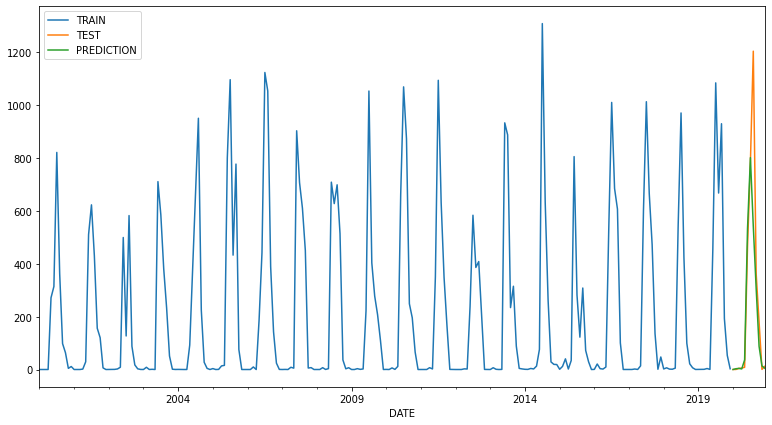

In [42]:
plotting(predictions)

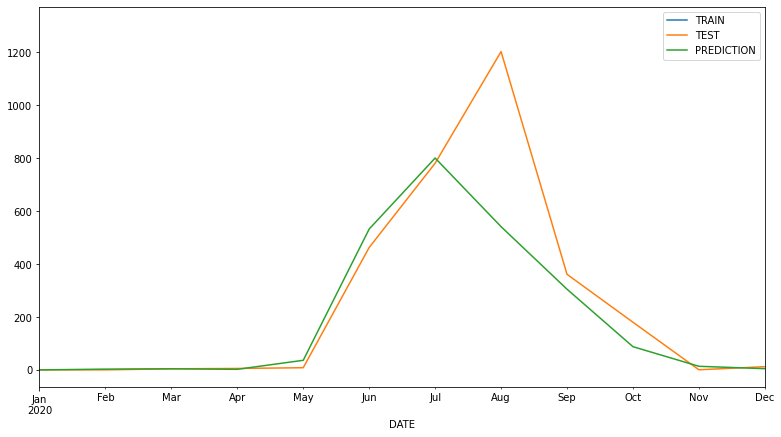

In [43]:
zoom_plotting(predictions)

In [44]:
print("Triple Seasonal Exponential Smoothing model: ")
metrics(test_data["Precipitation"],test_predictions)
print('\n')
print("Sarima paper model: ")
metrics(test_data["Precipitation"],paper_predictions)
print('\n')
print("SARIMA autoarima Smoothing model: ")
metrics(test_data["Precipitation"],predictions)

Triple Seasonal Exponential Smoothing model: 
MAE:  110.05221286730534
MSE:  37350.36905975688
RMSE:  193.26243571826595


Sarima paper model: 
MAE:  90.14075588291047
MSE:  45492.670315214775
RMSE:  213.29010833888844


SARIMA autoarima Smoothing model: 
MAE:  79.5698958198753
MSE:  37989.93229162172
RMSE:  194.91006205843175


-> Using Auto_arima gets better metrics

# 3. Non Linear Model: Artificial Neural Network 

In [45]:
df.head()

,Specific Humidity,Relative Humidity,Temperature,Precipitation
DATE,,,,
2000-01-01,8.06,48.25,23.93,0.00
2000-02-01,8.73,50.81,25.83,0.11
2000-03-01,8.48,42.88,26.68,0.01
2000-04-01,13.79,55.69,22.49,0.02
2000-05-01,17.40,70.88,19.07,271.14


In [46]:
df.shape

(252, 4)

Drop useless columns

In [47]:
df = df.drop(columns=['Specific Humidity','Relative Humidity','Temperature'],axis=1) 
df.head()

,Precipitation
DATE,
2000-01-01,0.00
2000-02-01,0.11
2000-03-01,0.01
2000-04-01,0.02
2000-05-01,271.14


## Prepare the input (X) and output (y) datasets


In [48]:
def create_dataset(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


Using the pacf plot to determine the best numbre of lags to include

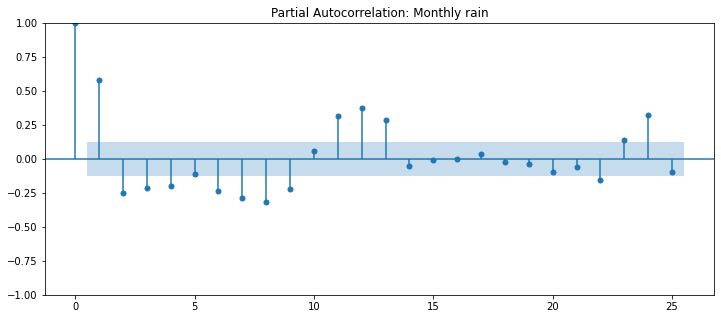

In [49]:
title='Partial Autocorrelation: Monthly rain'
plot_pacf(rain,title=title);

* The point where the values drop off significantly can be a good indication of how many lags to include.

In [50]:
p = 13             # Using  lagged observations
X, y = create_dataset(df.values, p)

In [51]:
print(X.shape)    #2D array 
print(y.shape)

(239, 13)
(239,)


## Train and Test Split

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

(191, 13)

## Normalize the data


In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the training data
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [54]:
# Reshape y to fit into the scaler
y_train = y_train.reshape(-1, 1)  # Reshape to 2D for scaling
y_test = y_test.reshape(-1, 1)

# Fit and transform the target variable
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

## the ANN Model

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from keras.layers import Dropout
from keras.layers import BatchNormalization


model = Sequential()
model.add(Dense(64, input_dim=13, activation='relu'))  # Input layer with 64 neurons
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout layer with 50% drop rate
model.add(Dense(32, activation='relu'))  # Hidden layer with 32 neurons
model.add(Dense(1))  # Output layer for regression


In [56]:
model.compile(optimizer='adam', loss='mean_squared_error')
model

In [57]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import datetime

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Create a TensorBoard callback
# Define a log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=10, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr, tensorboard_callback],
                    verbose=1)


Epoch 1/100
20/20 [==============================] - 1s 18ms/step - loss: 1.1262 - val_loss: 0.0920
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5946 - val_loss: 0.0909
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5366 - val_loss: 0.0878
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4043 - val_loss: 0.0895
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2939 - val_loss: 0.0961
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2945 - val_loss: 0.0883
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2655 - val_loss: 0.0923
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2424 - val_loss: 0.0924
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2173 - val_loss: 0.0945
Epoch 10/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1654 - val_loss: 0.0890
Epoch 11

In [58]:
# Start TensorBoard
%reload_ext tensorboard
%tensorboard --logdir logs/fit


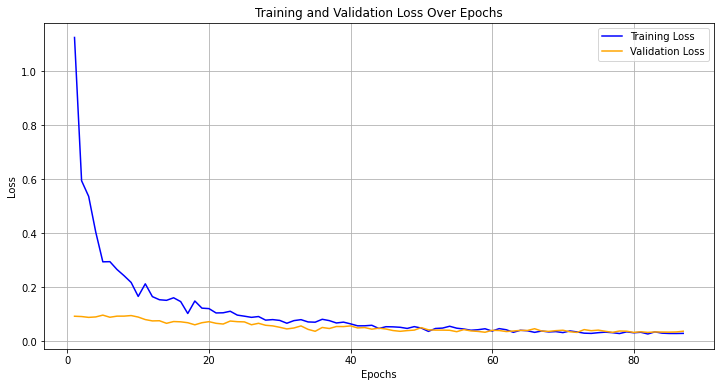

In [59]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for the number of epochs
epochs = range(1, len(loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')

# Adding titles and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plot
plt.show()

### Predict

In [60]:
pred = model.predict(X_test)

#### Inverse the normalization for predictions and true values


In [61]:
y_test_inv = scaler_y.inverse_transform(y_test)
predictions_inv = scaler_y.inverse_transform(pred)

#### Plot the results


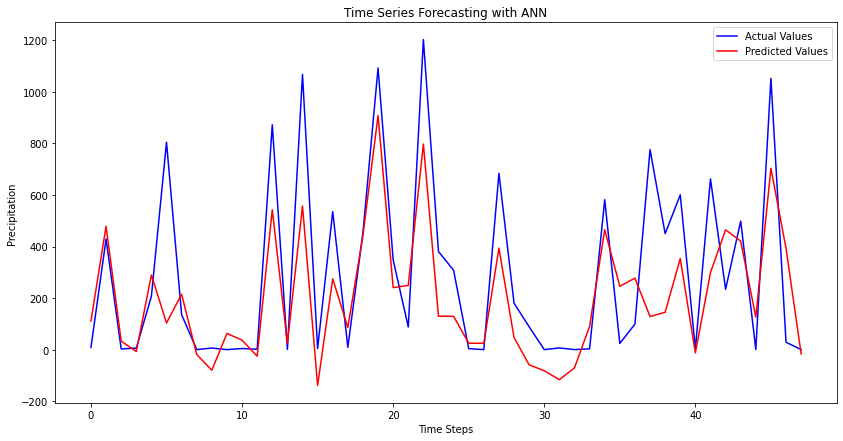

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Values', color='blue')
plt.plot(predictions_inv, label='Predicted Values', color='red')
plt.title('Time Series Forecasting with ANN')
plt.xlabel('Time Steps')
plt.ylabel('Precipitation')
plt.legend()
plt.show()

### Evaluate

In [63]:
print("Triple Seasonal Exponential Smoothing model: ")
metrics(test_data["Precipitation"],test_predictions)
print('\n')
print("Sarima paper model: ")
metrics(test_data["Precipitation"],paper_predictions)
print('\n')
print("SARIMA autoarima Smoothing model: ")
metrics(test_data["Precipitation"],predictions)
print('\n')
print("ANN model: ")
metrics(y_test_inv,predictions_inv)

Triple Seasonal Exponential Smoothing model: 
MAE:  110.05221286730534
MSE:  37350.36905975688
RMSE:  193.26243571826595


Sarima paper model: 
MAE:  90.14075588291047
MSE:  45492.670315214775
RMSE:  213.29010833888844


SARIMA autoarima Smoothing model: 
MAE:  79.5698958198753
MSE:  37989.93229162172
RMSE:  194.91006205843175


ANN model: 
MAE:  170.2021556822459
MSE:  54548.97545342182
RMSE:  233.5572209404407


# 4.XGBoost Model

#### using Grid Search Cross Validation to get the best hyperparameters for the XGBoost model

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

# Define the parameter grid
param_distributions = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': np.arange(3, 10, 1),
    'learning_rate': np.logspace(-3, 0, 10),
    'subsample': np.linspace(0.7, 1.0, 5),
    'colsample_bytree': np.linspace(0.7, 1.0, 5)
}

xgb_model = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=xgb_model, 
                                   param_distributions=param_distributions,
                                   n_iter=50,  # Number of parameter settings that are sampled
                                   scoring='neg_mean_squared_error', 
                                   cv=3, 
                                   verbose=1, 
                                   random_state=42,
                                   n_jobs=-1)  # Use all available cores

random_search.fit(X_train, y_train.ravel())

# Best parameters found 
print(f"Best parameters: {random_search.best_params_}")
best_xgb_model = random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


In [65]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, subsample=0.9)
xgb_model.fit(X_train, y_train.ravel())  # Use .ravel() to flatten y_train

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

#### predict

In [66]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Rescale the predictions back to the original scale (since you scaled the data)
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test)


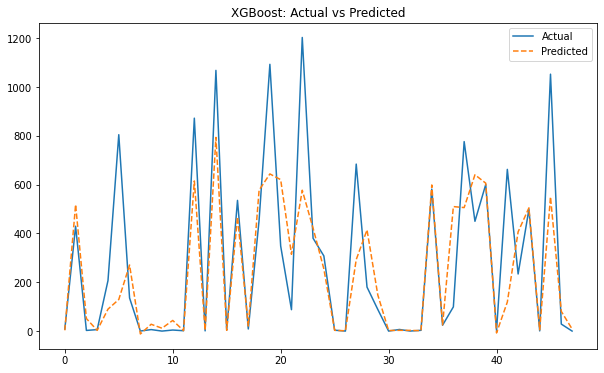

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted", linestyle='dashed')
plt.title("XGBoost: Actual vs Predicted")
plt.legend()
plt.show()

## Evaluate

In [68]:
print("Triple Seasonal Exponential Smoothing model: ")
metrics(test_data["Precipitation"],test_predictions)
print('\n')
print("Sarima paper model: ")
metrics(test_data["Precipitation"],paper_predictions)
print('\n')
print("SARIMA autoarima Smoothing model: ")
metrics(test_data["Precipitation"],predictions)
print('\n')
print("ANN model: ")
metrics(y_test_inv,predictions_inv)
print('\n')
print("XGBoost model: ")
metrics(y_test_rescaled,y_pred_rescaled)

Triple Seasonal Exponential Smoothing model: 
MAE:  110.05221286730534
MSE:  37350.36905975688
RMSE:  193.26243571826595


Sarima paper model: 
MAE:  90.14075588291047
MSE:  45492.670315214775
RMSE:  213.29010833888844


SARIMA autoarima Smoothing model: 
MAE:  79.5698958198753
MSE:  37989.93229162172
RMSE:  194.91006205843175


ANN model: 
MAE:  170.2021556822459
MSE:  54548.97545342182
RMSE:  233.5572209404407


XGBoost model: 
MAE:  134.54144870857397
MSE:  51179.2934919405
RMSE:  226.22841000179554


#### Because we are prioritizing MAE (average absolute error), SARIMA AutoARIMA might be a close contender due to its lower MAE, although it has a slightly higher RMSE than the smoothing model.

## Model evaluation using all the data

In [69]:
train_data = df

In [70]:
model = SARIMAX(train_data['Precipitation'],order=(1,0,0),seasonal_order=(2,0,[1],12))
results = model.fit()
Forecast_sarima = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(1,0,0)(2,0,[1],12) Forecast')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88314D+00    |proj g|=  4.58238D+00


 This problem is unconstrained.



At iterate    5    f=  6.74351D+00    |proj g|=  4.18861D-02

At iterate   10    f=  6.73227D+00    |proj g|=  8.05889D-03

At iterate   15    f=  6.72657D+00    |proj g|=  6.34961D-03

At iterate   20    f=  6.63812D+00    |proj g|=  2.73786D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     37      1     0     0   2.738D-02   6.638D+00
  F =   6.6381226404690512     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


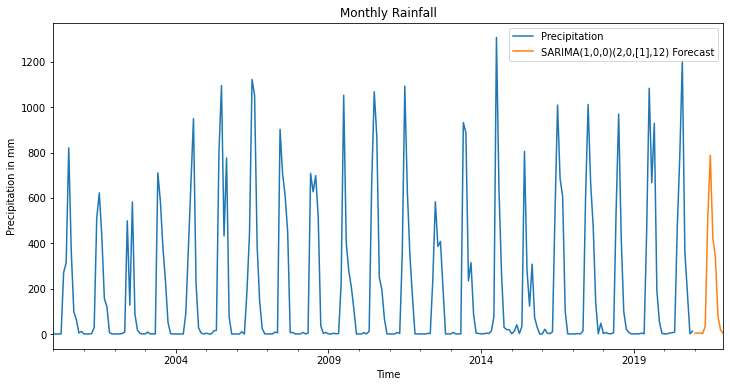

In [71]:
# Plot predictions against known values
title = 'Monthly Rainfall'
ylabel='Precipitation in mm'
xlabel='Time'

ax = train_data['Precipitation'].plot(legend=True,figsize=(12,6),title=title)
Forecast_sarima.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);